In [2]:
from keras import backend as K
from models.keras_ssd7 import build_model

Using TensorFlow backend.


# Load model

In [7]:

weight_path = '../Models/ssd7_TL_epoch-03_weights_Carla.h5'

K.clear_session() # Clear previous models from memory.


img_height = 600 # Height of the input images
img_width = 800 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 8 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size
model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='inference',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Load some weights
model.load_weights(weight_path, by_name=True)



In [8]:
#print(model.get_config())
model.get_config()

{'name': 'model_1',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 600, 800, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'identity_layer',
   'class_name': 'Lambda',
   'config': {'name': 'identity_layer',
    'trainable': True,
    'function': ('4wEAAAAAAAAAAQAAAAEAAABTAAAAcwQAAAB8AFMAKQFOqQApAdoGdGVuc29ycgEAAAByAQAAAPpd\nL2hvbWUvc3JhL1VkYWNpdHkvU2VsZkRyaXZpbmdDYXIvQ2FyTkQtQ2Fwc3RvbmUvVHJhaW5pbmdT\nY3JpcHQvc3NkX2tlcmFzL21vZGVscy9rZXJhc19zc2Q3LnB52g5pZGVudGl0eV9sYXllcvcAAABz\nAgAAAAAB\n',
     None,
     None),
    'function_type': 'lambda',
    'output_shape': (600, 800, 3),
    'output_shape_type': 'raw',
    'arguments': {}},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'input_mean_normalization',
   'class_name': 'Lambda',
   'config': {'name': 'input_mean_normalization',
    'trainable': True,
    'function': ('4wEAAAAAAAAAAQAAAAMAAAATAAAAcw4AAAB

# Get Image

In [9]:
from glob import glob
import numpy as np
#from keras.preprocessing import image
#from imageio import imread
from PIL import Image 

# Set the image size.
img_path = '../TrainData/Carla/'
img_height = 600
img_width = 800
imgNr = 5

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# load one image
image_files = glob(img_path + '*.jp*')

imgFile = image_files[imgNr]
print(imgFile)
#img = image.load_img(imgFile, target_size=(img_height, img_width))
img_org = np.asarray(Image.open(imgFile))
orig_images.append(img_org)
print(img_org.shape)
img_org = np.expand_dims(img_org, axis=0) # add a dimension to have a batch dim. 
print(img_org.shape)


../TrainData/Carla/yellow_frame0837.jpg
(600, 800, 3)
(1, 600, 800, 3)


In [10]:
import cv2

# Get image using cv2 instead of PIL
img_org2 = cv2.imread(imgFile)
img_org2 = cv2.cvtColor(img_org2, cv2.COLOR_BGR2RGB ) 
img_org2 = np.expand_dims(img_org2, axis=0)

# Predict images class

In [16]:
y_pred = model.predict(img_org2)

# Filter predictions
confidence_threshold = 0.8
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]


# Print output

In [17]:
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0][:,0:2])


Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[2.   0.97]]


# Plot the predicted image output

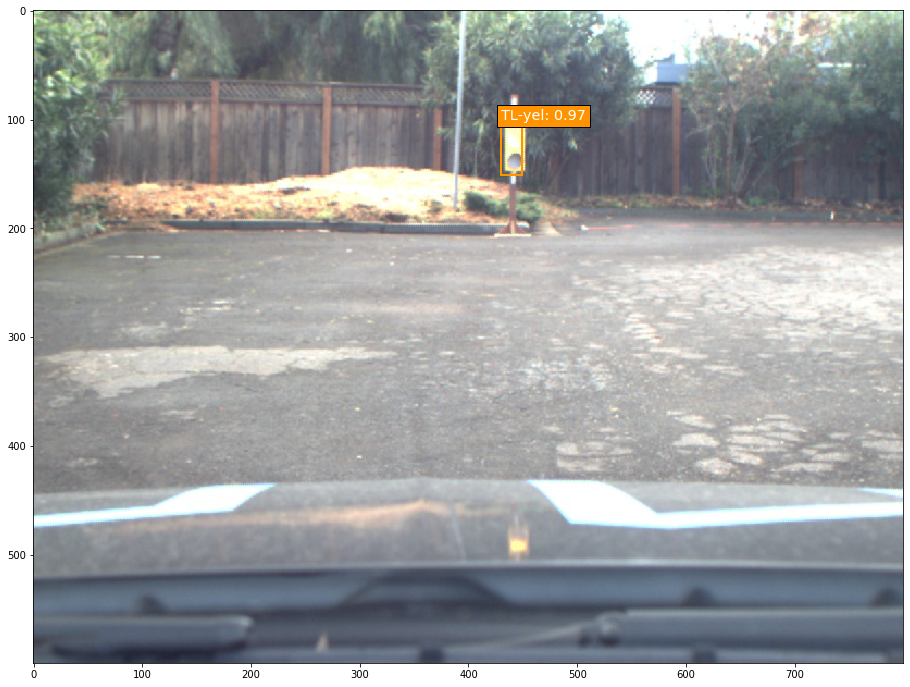

In [18]:
from matplotlib import pyplot as plt
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['NA','TL-gre', 'TL-yel', 'TL-red', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs


plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})